In [2]:
import math
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl

import warnings
from scipy.optimize import OptimizeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning) 

### Helper Methods

In [3]:
imageFolder = 'imgs\\'
dataFolder  = 'bin\\results\\'

def removeDups(x):
  return list(dict.fromkeys(x))

def filterTable(T, hashes=-1, loops=-1, numthreads=-1):
    res = T
    if(hashes >= 0):
        res = res[res['hashes'] <= hashes]
    if(loops >= 0):
        res = res[res['loops'] <= loops]
    if(numthreads >= 0):
        res = res[res['numthreads'] <= numthreads]
    return res

def getTableString(s):
    if s == "cc":
        return "Cleary-Cuckoo"
    if s == "c":
        return "Cleary"
    else:
        return ""

def getTitleString(s):
    if s == "CPU":
        return "CPU"
    if s == "CPU_REHASH":
        return "CPU with rehashing"
    if s == "GPU":
        return "GPU"
    if s == "GPU_REHASH":
        return "GPU with rehashing"
    else:
        return ""

def outlierFilter(T):
    print("Highest allowed",T['time'].mean() + 3*T['time'].std())
    print("Lowest allowed",T['time'].mean() - 3*T['time'].std())
    highest = T['time'].mean() + 3*T['time'].std()
    lowest = T['time'].mean() - 3*T['time'].std()
    
    new_df = T[(T['time'] < highest) & (T['time'] > lowest)]
    return new_df

## Data Importing + Cleaning

# Exploration

### Maximum Size

In [3]:
#Import max table
def importMax(filename):
    #ccmax = pd.read_csv (r'results\benchmax.csv', index_col=False)
    ccmax = pd.read_csv (filename, index_col=False)
    #Average the samples
    ccmax = ccmax.groupby(['tablesize', 'hashes', 'loops', 'rehashes']).mean().drop(['samples'], axis=1)
    ccmax = ccmax.reset_index() 
    ccmax['occupation'] = ccmax['max']/pow(2,ccmax['tablesize'])
    return ccmax
    
ccmax_CPU = importMax(dataFolder + '\\benchmax-CPU.csv')

In [4]:
ccmax_CPU

tablesize  hashes  loops  rehashes      max  occupation
0             5       1      0         0        0    0.000000
1             5       1     15         0        9    0.281250
2             5       1     30         0        1    0.031250
3             5       1     45         0        7    0.218750
4             5       1     60         0        4    0.125000
...         ...     ...    ...       ...      ...         ...
2689         21       7    135         0  1900935    0.906436
2690         21       7    150         0  1929282    0.919953
2691         21       7    165         0  1971597    0.940131
2692         21       7    180         0  1989757    0.948790
2693         21       7    195         0      198    0.000094

[2694 rows x 6 columns]

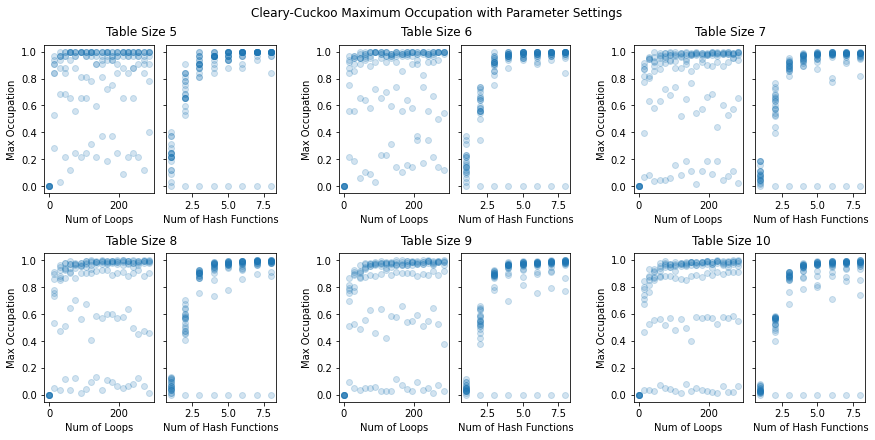

In [5]:
def PlotMaxMatrix(T, table="", dataset="", MAX_TABLESIZE=math.inf):
    #Average out the Intervals
    T_avg = T[T['tablesize'] <= MAX_TABLESIZE]
    tables = removeDups(T_avg['tablesize'])
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 3*math.ceil(len(tables)/3)))
    subfigs = fig.subfigures(math.ceil(len(tables)/3), 3, wspace=0.07)
    
    fig.suptitle(getTableString(table) + " Maximum Occupation with Parameter Settings")
    
    #Iterate over tablesizes
    x=0
    for i in tables:
        tableN = T_avg[T_avg['tablesize'] == i].drop(['tablesize'], axis=1)
        axs = subfigs[math.floor(x/3), x%3].subplots(1,2, sharey=True)
        axs[0].scatter(tableN["loops"],tableN["occupation"], alpha=0.2)
        axs[1].scatter(tableN["hashes"],tableN["occupation"], alpha=0.2)
        #axs[2].scatter(tableN["rehashes"],tableN["occupation"], alpha=0.2)
        axs[0].set(xlabel='Num of Loops', ylabel='Max Occupation')
        axs[1].set(xlabel='Num of Hash Functions')
        #axs[2].set(xlabel='Rehashes')
        subfigs[math.floor(x/3), x%3].suptitle("Table Size " + str(i))
        x+=1
        
        for ax in fig.get_axes():
            ax.label_outer()
    
    if dataset!="":
        filename = imageFolder + table + "MaxMat_" + dataset + ".png"
        fig.savefig(filename, bbox_inches='tight')
        
    

PlotMaxMatrix(ccmax_CPU, "cc", "CPU", 10)

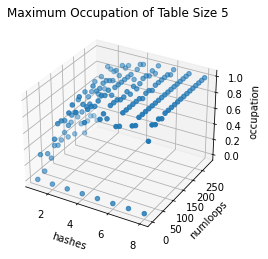

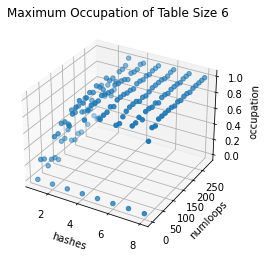

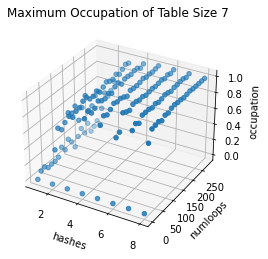

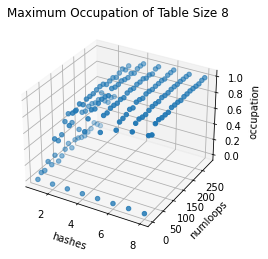

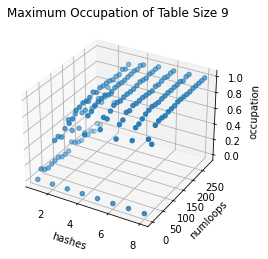

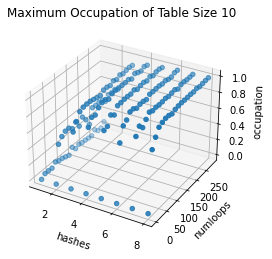

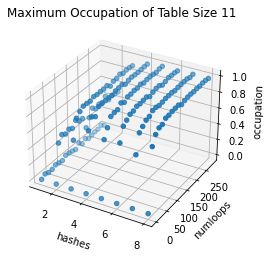

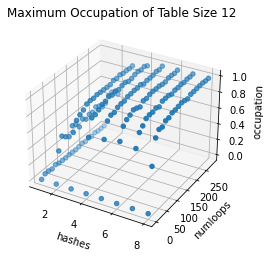

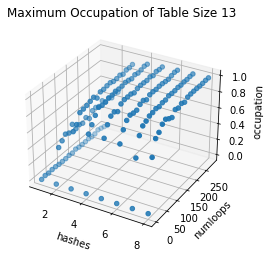

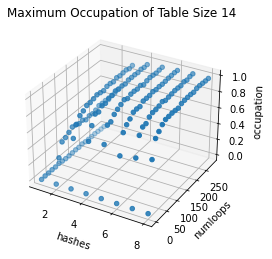

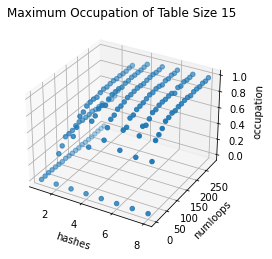

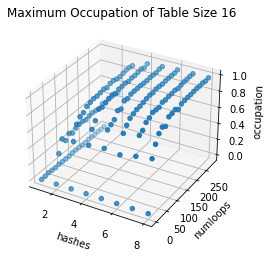

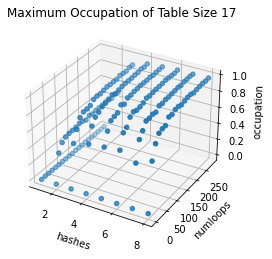

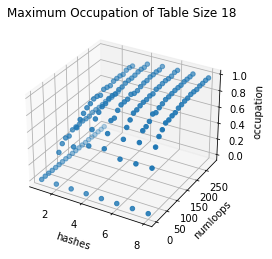

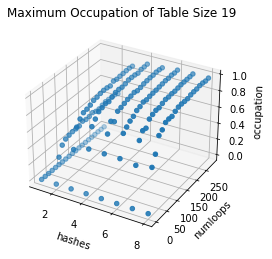

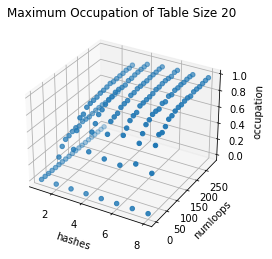

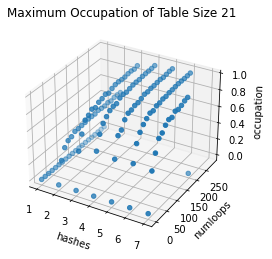

In [6]:
def plotMax3D(T):
    #Iterate over tablesizes
    for i in removeDups(T['tablesize']):
        tableN = T[T['tablesize'] == i]
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(tableN['hashes'], tableN['loops'], tableN['occupation'], cmap='Greens')
        ax.set_title('Maximum Occupation of Table Size ' + str(i))
        ax.set_xlabel('hashes')
        ax.set_ylabel('numloops')
        ax.set_zlabel('occupation');
        
plotMax3D(ccmax_CPU)

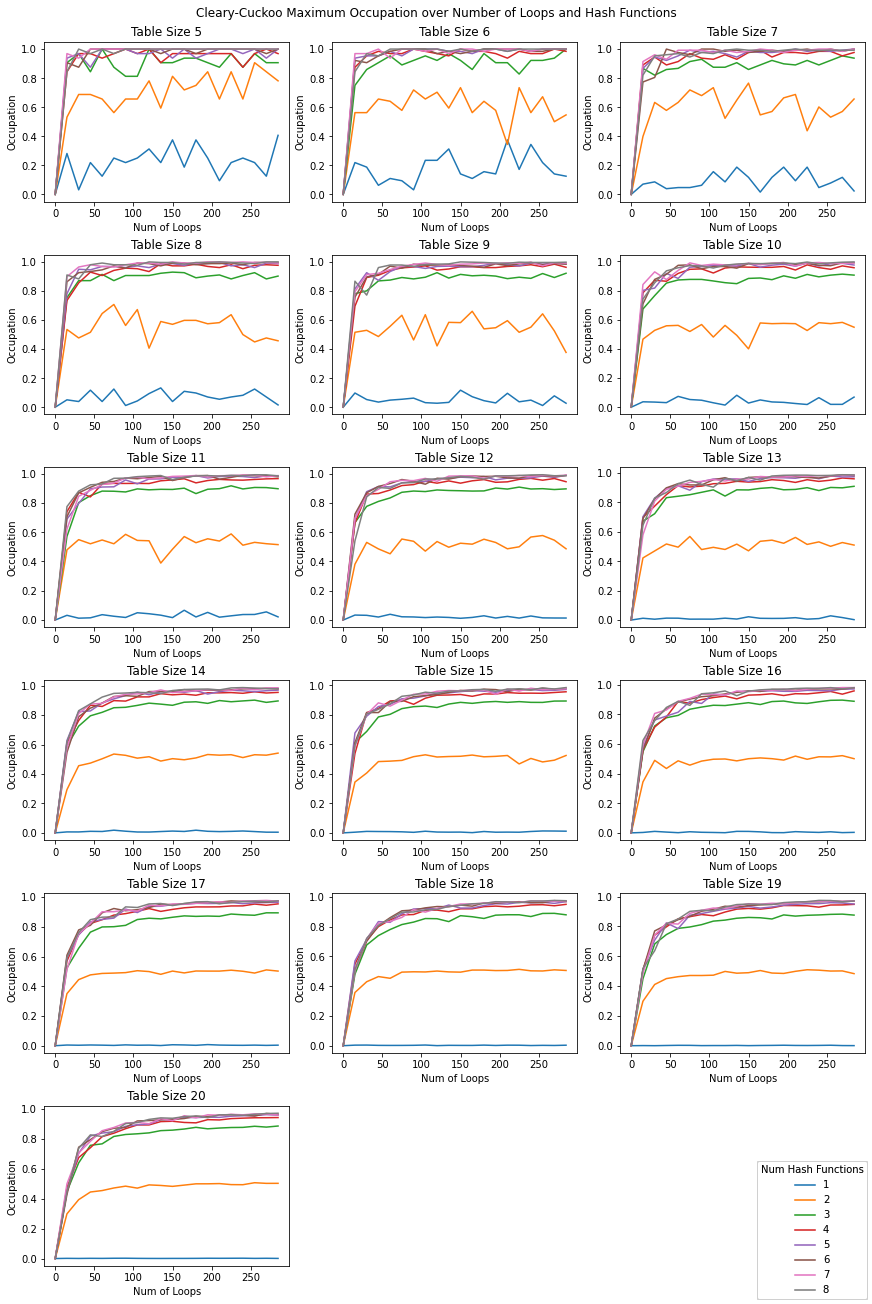

In [7]:
def plotMax2D(T, hashes=False, table="", dataset="", MAX_TABLESIZE=math.inf):
    T_copy = T[T['tablesize'] <= MAX_TABLESIZE]
    tables = removeDups(T_copy['tablesize'])
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 3*math.ceil(len(tables)/3) ))
    fig.suptitle(getTableString(table) +" Maximum Occupation over Number of Loops and Hash Functions")
    subfigs = fig.subplots(math.ceil(len(tables)/3),3)
    
    #Iterate over tablesizes
    x=0
    for i in tables :
        tableN = T_copy[T_copy['tablesize'] == i]
        
        if hashes:
            tableN = tableN.groupby(['hashes', 'loops', 'occupation']).mean().drop(['rehashes'], axis=1)
            tableN = tableN.reset_index()
        else:
            tableN = tableN[tableN['rehashes'] == 0]
            
        tableN = tableN[tableN['hashes'] <= 20]
        #Iterate over the number of threads
        for j in removeDups(tableN['hashes']):
            threadN = tableN[tableN['hashes'] == j]
            subfigs[math.floor(x/3), x%3, ].plot(threadN['loops'], threadN['occupation'], label=j)
        subfigs[math.floor(x/3), x%3].title.set_text("Table Size " + str(i))
        subfigs[math.floor(x/3), x%3].set(xlabel="Num of Loops", ylabel='Occupation')
        
        x+=1
        fig.legend(subfigs[0,0].get_lines(), removeDups(tableN['hashes']),title="Num Hash Functions",  loc="lower right")
    
    #clean empty plots
    numEmpty = len(tables)%3
    if numEmpty !=0 : numEmpty = 3 - numEmpty
    for i in range(1, numEmpty+1):
        subfigs[-1,-1*i].axis('off')
    
    plt.show()
    
    if dataset!="":
        filename = imageFolder + table + "Max_" + dataset + ".png"
        fig.savefig(filename, bbox_inches='tight')
    
        
plotMax2D(ccmax_CPU, False, "cc", "CPU", 20)

In [8]:
ccmax_4_CPU = importMax(dataFolder + '\\benchmax_4-CPU.csv')
print(ccmax_4_CPU)

     tablesize  hashes  loops  rehashes           max  occupation
0            5       4      0         0  0.000000e+00    0.000000
1            5       4     15         0  2.800000e+01    0.875000
2            5       4     30         0  3.033333e+01    0.947917
3            5       4     45         0  3.066667e+01    0.958333
4            5       4     60         0  2.966667e+01    0.927083
..         ...     ...    ...       ...           ...         ...
395         24       4    225         0  1.542856e+07    0.919614
396         24       4    240         0  1.546711e+07    0.921911
397         24       4    255         0  1.550098e+07    0.923931
398         24       4    270         0  1.558297e+07    0.928818
399         24       4    285         0  1.562958e+07    0.931596

[400 rows x 6 columns]


In [9]:
def logfunc(x, a, b, c):
    return a * (np.log(x + b))+c

def logfunc_inv(y, a, b, c):
    return (np.e**((y-c)/a)) - b

def logifunc(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off

def logifunc_inv(y,A,x0,k,off):
    return (np.log((A/(y-off))-1))/-k + x0

In [10]:
#Storing for later 
def testFunct():
    x = np.arange(1, 300, 0.1)
    y = [funct(val, *popt) for val in x]
    plt.plot(x, y, label="y(x)")

    y_1prime = np.gradient(y, 0.01)
    plt.plot(x, y_1prime, label="y_1prime(x)")
    y_2prime = np.gradient(y_1prime, 0.01)
    plt.plot(x, y_2prime, label="y_2prime(x)")

    plt.show()

    x_zero_index = np.where(np.diff(np.sign(y_2prime)))[0]
    x_zero_value = x[x_zero_index][0]
    print(x_zero_value)
    loopnr = x_zero_value
    yval = funct(x_zero_value, *popt)

    tablesize      loops
0           5  14.921336
1           6  13.561754
2           7  18.809049
3           8  20.502138
4           9  22.749272
5          10  29.234323
6          11  31.096445
7          12  32.093710
8          13  37.779949
9          14  35.704410
10         15  37.840719
11         16  42.637421
12         17  44.348670
13         18  47.374219
14         19  47.206965
15         20  49.012556
16         21  54.571654
17         22  56.388393
18         23  57.459770
19         24  60.527813
[ 1.82372633e+04 -2.60749645e+02  1.76799265e-02 -1.80594901e+04]


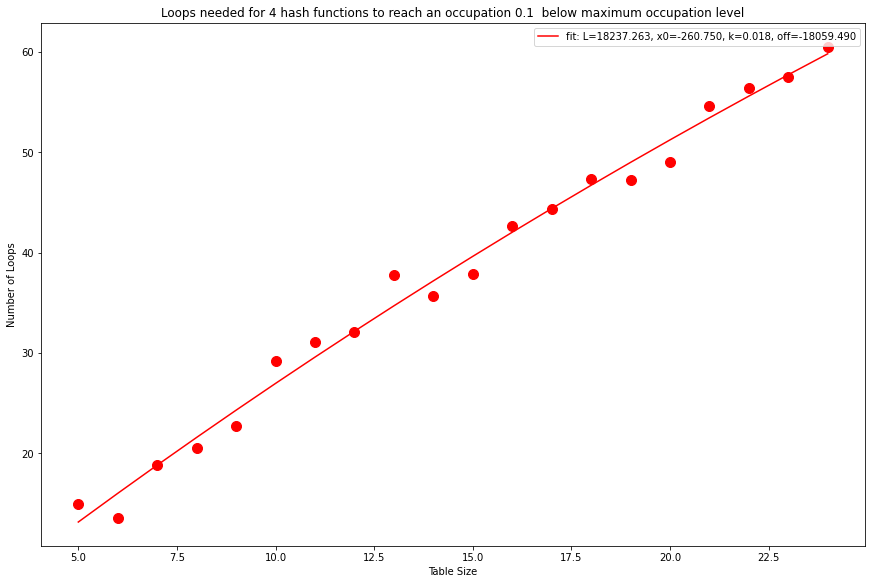

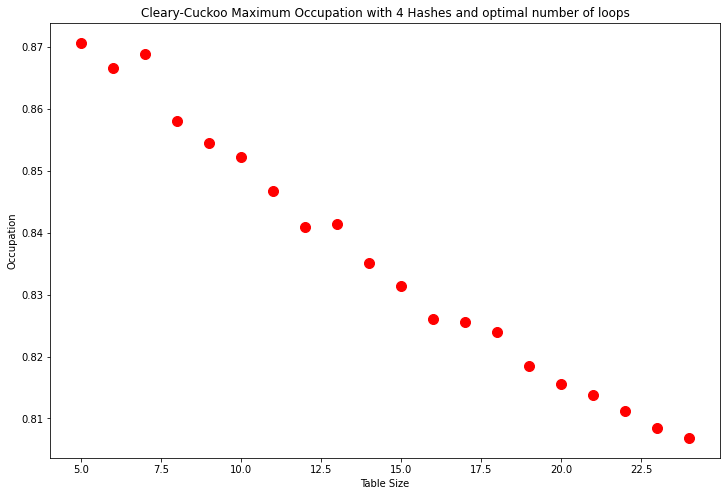

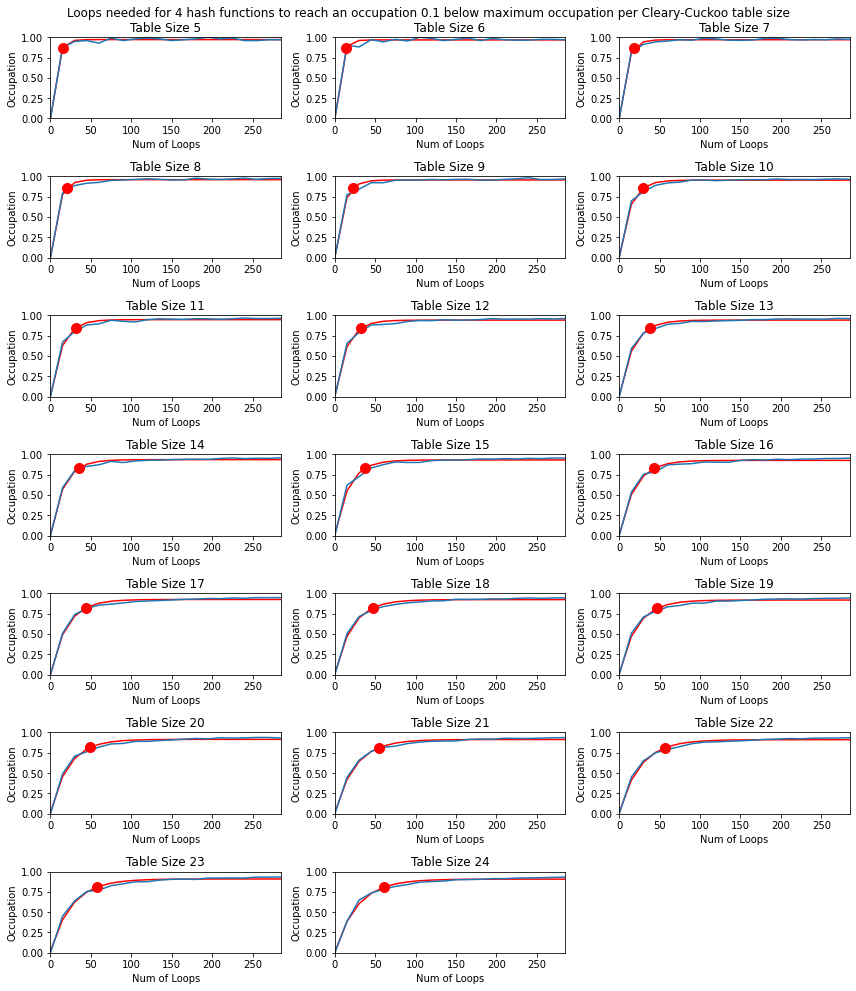

In [11]:
def plotOccupationPercentile(T, H, P, funct, funct_inv, MAX_TABLESIZE=math.inf):
    tables = removeDups((T[T['tablesize'] <= MAX_TABLESIZE])['tablesize'])
    
    fig = plt.figure(1,constrained_layout=True, figsize=(12, 8))
    ax2 = fig.gca()
    ax2.set(xlabel='Table Size')
    ax2.set(ylabel='Number of Loops')
    ax2.set(title='Loops needed for ' + str(H) +  ' hash functions to reach an occupation '+ str(P) + '  below maximum occupation level' )
    
    fig3 = plt.figure(3,constrained_layout=False, figsize=(12, 8))
    ax3 = fig3.gca()
    ax3.set(xlabel='Table Size')
    ax3.set(ylabel='Occupation')
    ax3.set(title='Cleary-Cuckoo Maximum Occupation with 4 Hashes and optimal number of loops')
    
    fig2 = plt.figure(0, figsize=(12, 2*math.ceil(len(tables)/3) ))
    subfigs = fig2.subplots( math.ceil(len(tables)/3), 3)
    
    fig2.suptitle('Loops needed for ' + str(H) + " hash functions to reach an occupation "+ str(P) + " below maximum occupation per Cleary-Cuckoo table size")
    
    loops = []
    perr = [0,0,0,0]
    
    #Iterate over tablesizes
    c=0
    for i in tables:
        tableN = T[T['tablesize'] == i]
        tableN = tableN[tableN['hashes'] == H]
        
        tableN = tableN.groupby(['loops', 'occupation']).mean().drop(['rehashes'], axis=1)
        tableN = tableN.reset_index()
        
        maxOcc = tableN['occupation'].max()
                    
        x = np.array(tableN['loops'])
        y = np.array(tableN['occupation'])
        
        A = (tableN.max() - tableN.min())['occupation']
        #x0 = (tableN.iloc[(tableN['occupation']-halfWay).abs().argsort()[:1]])['loops'].values[0]
        
        if(funct == logifunc):
            popt, pcov = curve_fit(funct, x, y, p0=[A,0,0,0], maxfev=100000)
        else:
            popt, pcov = curve_fit(funct, x, y, maxfev=100000)
        
        #print("Error on variables:")    
        #print(np.sqrt(np.diag(pcov)))
        
        
        subfigs[math.floor(c/3),c%3].plot(x, funct(x, *popt), 'r-', label='fit')
        subfigs[math.floor(c/3),c%3].plot(tableN['loops'], tableN['occupation'])
        
        
        
        yval = popt[0] + popt[3] - P
        loopnr = funct_inv(yval, *popt)
        
        
        loops.append([i, loopnr])
        
        if loopnr.any():
            subfigs[math.floor(c/3),c%3].plot(loopnr, yval, marker="o", markersize=10, color="red")
            subfigs[math.floor(c/3), c%3].title.set_text("Table Size " + str(i))
            subfigs[math.floor(c/3), c%3].set(xlabel="Num of Loops", ylabel='Occupation')
            subfigs[math.floor(c/3), c%3].set_ylim([0,1])
            subfigs[math.floor(c/3), c%3].set_xlim([0,tableN['loops'].max()])
            ax2.plot(i, loopnr, marker="o", markersize=10, color="red")
            ax3.plot(i, yval, marker="o", markersize=10, color="red")
        c+=1
    
    #clean empty plots
    numEmpty = len(tables)%3
    if numEmpty !=0 : numEmpty = 3 - numEmpty
    for i in range(1, numEmpty+1):
        subfigs[-1,-1*i].axis('off')
    
    #TEMP
    #tablesizes.pop()
    #loops.pop()
    
    temp = pd.DataFrame(loops, columns=['tablesize', 'loops'])
    temp.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Drop rows with NaN
    temp.dropna(inplace=True)
    print(temp)
    
    A = (temp.max() - temp.min())['loops']
    halfWay = temp.max()['loops'] - (A/2)
    x0 = (temp.iloc[(temp['loops']-halfWay).abs().argsort()[:1]])['tablesize'].values[0]
    
    popt, pcov = curve_fit(funct, temp['tablesize'], temp['loops'], p0=[A,x0,0,0], maxfev=100000)
    ax2.plot(temp['tablesize'], funct(temp['tablesize'], *popt), 'r-', label='fit: L=%5.3f, x0=%5.3f, k=%5.3f, off=%5.3f' % tuple(popt))
    ax2.legend()
        
    plt.tight_layout()
    
    fig3.savefig(imageFolder + 'MaxOcc.png', bbox_inches='tight')
    fig2.savefig(imageFolder + 'FitOcc.png', bbox_inches='tight')
    fig.savefig(imageFolder + 'FitLoops.png', bbox_inches='tight')
    
    print(popt)
    
plotOccupationPercentile(ccmax_4_CPU, 4 , 0.1, logifunc, logifunc_inv)

In [12]:
logifunc(5, 18237.2633, -260.749645,  .0176799265, -18059.4901)

13.140038562640257

## Insertion Times

In [13]:
#Import Table
def importFill(filename):
    df = pd.read_csv (filename, index_col=False)

    #Get the number of intervals
    numIntervals = df['interval'].max()
    df['occupation'] = df['interval']/numIntervals
    
    #Filter by table type
    ccfill = df[df['type'] == "cuc"]
    
    #Remove Times after Fail
    ccfill = ccfill[ccfill["time"] != -1]
    
    #Filter lookup and insert
    ccfill_ins = ccfill[ccfill['test'].str.contains("INS")]
    ccfill_look = ccfill[ccfill['test'].str.contains("LOOK")]
    
    return ccfill_ins, ccfill_look

ccfill_ins_CPU, ccfill_look_CPU = importFill(dataFolder + '\\benchfill-CPU.csv')
ccfill_ins_GPU, ccfill_look_GPU = importFill(dataFolder + '\\benchfill-GPU.csv')


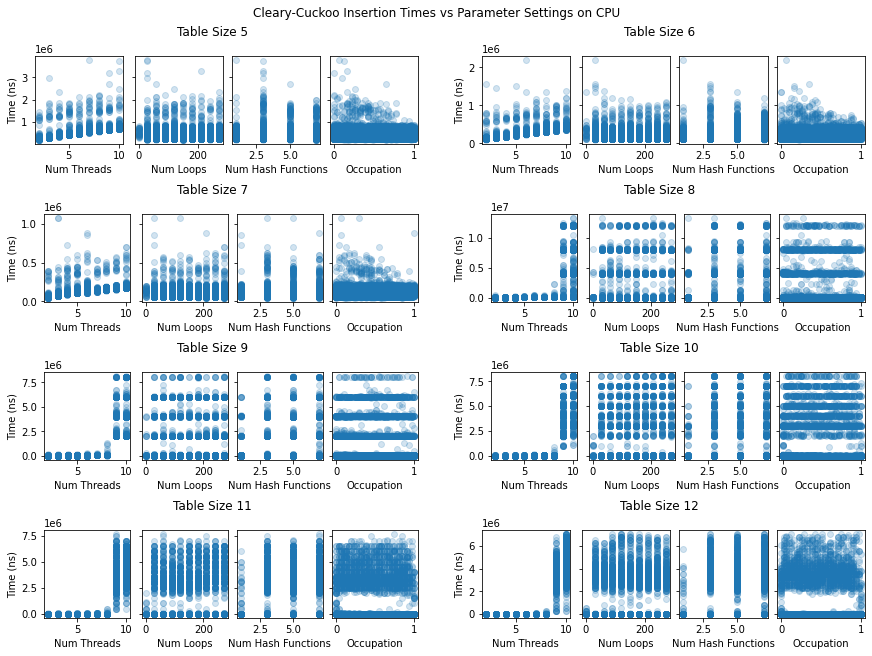

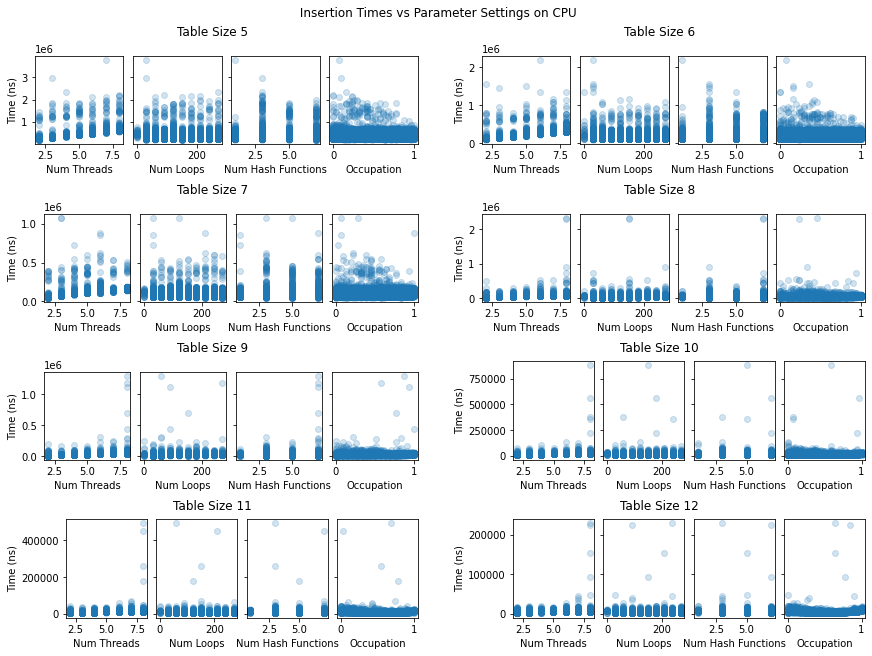

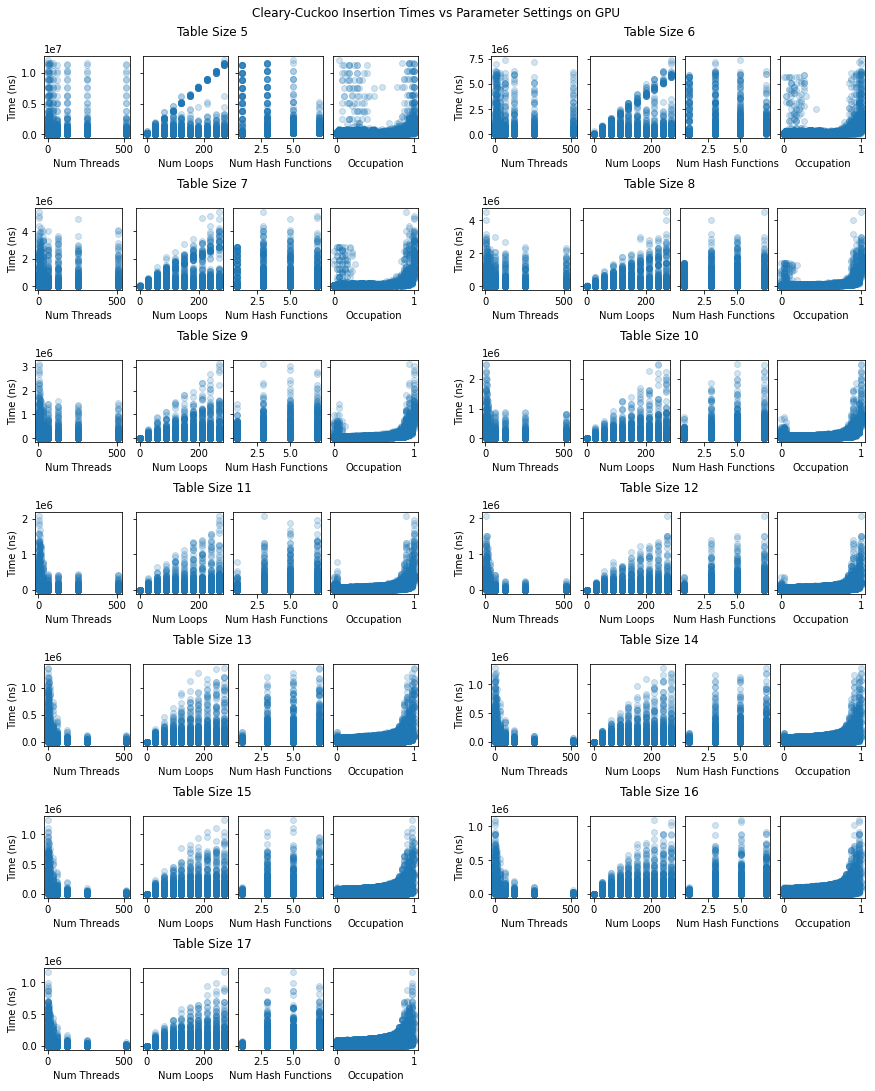

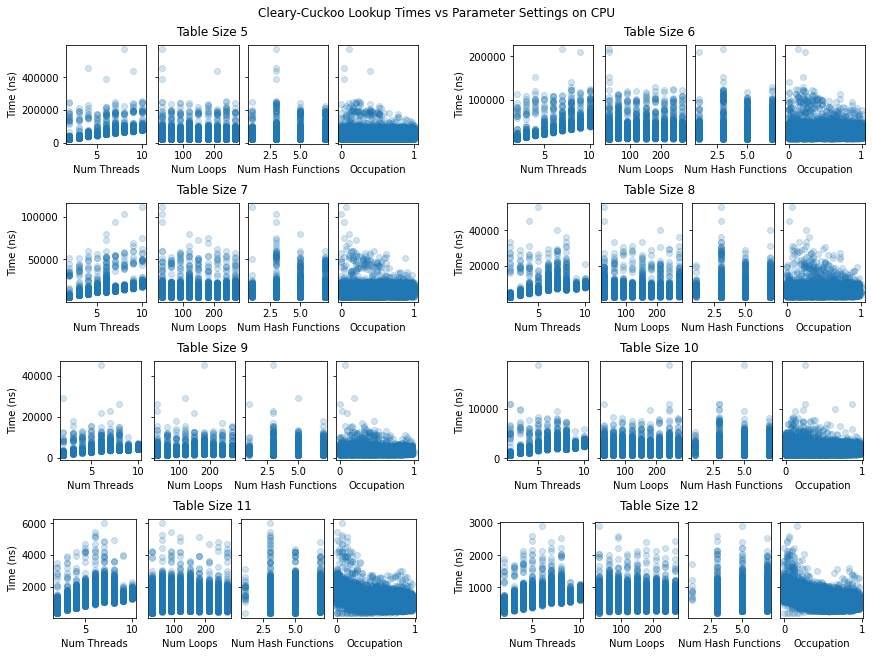

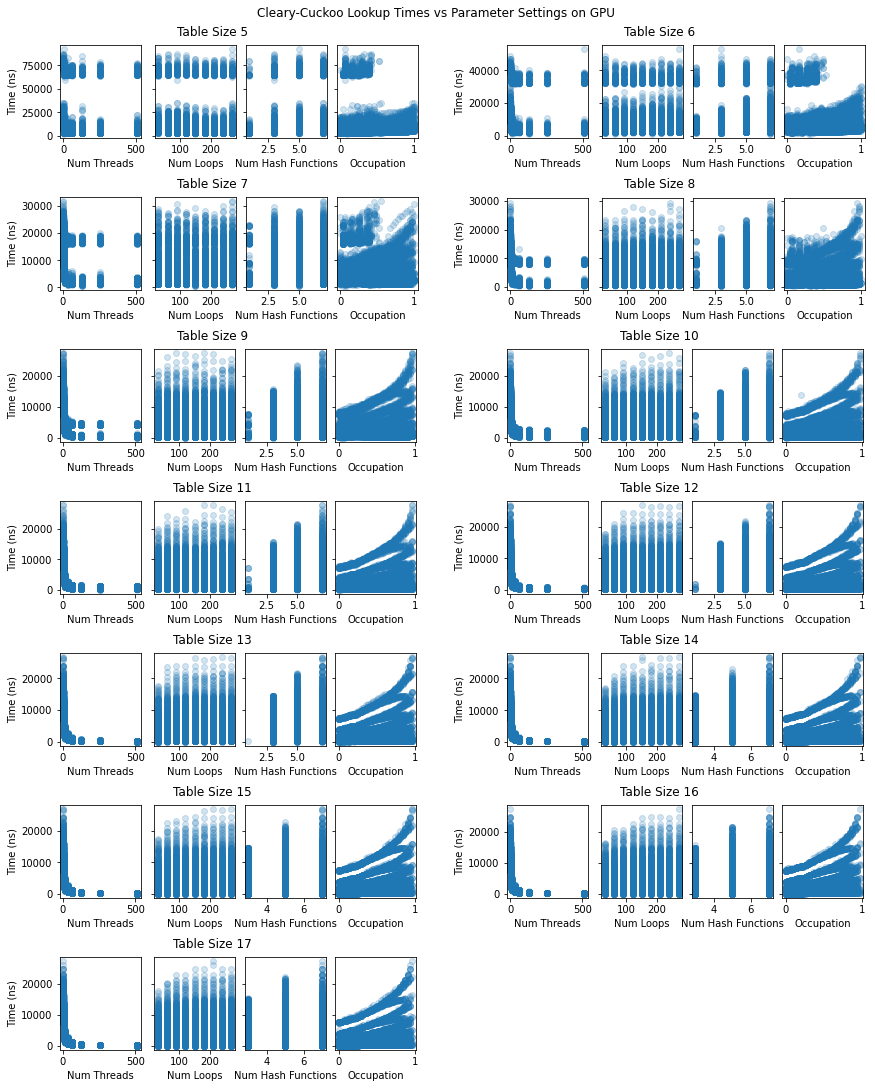

In [14]:
def PlotInsMatrix(T, table="", dataset="", rehashes=False, collisions=False, insertion=True, MAX_TABLESIZE=math.inf):
    tables = removeDups((T[T['tablesize'] <= MAX_TABLESIZE])['tablesize'])
    #Average out the Intervals
    T_avg = T.groupby(['tablesize', 'numthreads', 'loops', 'collision_percentage', 'collision_depth', 'rehashes', 'hashes', 'interval']).mean().drop(['samples'], axis=1)
    T_avg = T_avg.reset_index() 
    
    #Iterate over tablesizes
    fig = plt.figure(constrained_layout=True, figsize=(12, 3*math.ceil(len(tables)/3) ))
    subfigs = fig.subfigures(math.ceil(len(tables)/2), 2, wspace=0.07)
    
    figType = "Insertion"
    if not insertion:
        figType = "Lookup"
    fig.suptitle(getTableString(table) + " " + figType + " Times vs Parameter Settings on " + getTitleString(dataset))
    
    x=0
    for i in tables:
        tableN = T_avg[T_avg['tablesize'] == i].drop(['tablesize'], axis=1)
        
        numplots = 4
        
        if collisions:
            numplots = numplots + 2
        if rehashes:
            numplots = numplots + 1
        
        axs = subfigs[math.floor(x/2), x%2].subplots(1,numplots, sharey=True)
        axs[0].scatter(tableN["numthreads"],tableN["time"], alpha=0.2)
        axs[1].scatter(tableN["loops"],tableN["time"], alpha=0.2)
        axs[2].scatter(tableN["hashes"],tableN["time"], alpha=0.2)
        axs[3].scatter(tableN["occupation"],tableN["time"], alpha=0.2)
        if rehashes:
            axs[4].scatter(tableN["rehashes"],tableN["time"], alpha=0.2)
            
        axs[0].set(xlabel='Num Threads', ylabel='Time (ns)')
        axs[1].set(xlabel='Num Loops')
        axs[2].set(xlabel='Num Hash Functions')
        axs[3].set(xlabel='Occupation')
        if rehashes:
            axs[4].set(xlabel='Rehashes')
            
        
        if collisions:
            axs[5].scatter(tableN["collision_percentage"],tableN["time"], alpha=0.2)
            axs[6].scatter(tableN["collision_depth"],tableN["time"], alpha=0.2)
            axs[5].set(xlabel='Collision %')
            axs[6].set(xlabel='Collision Depth')
        
        subfigs[math.floor(x/2),x%2].suptitle("Table Size " + str(i))
        
        
        x+=1
        
        
        
        for ax in fig.get_axes():
            ax.label_outer()
            
    plt.show()
            
    if dataset!="":
        filename = table + "FillMat_" + figType + "_" + dataset + ".png"
        fig.savefig(imageFolder + filename, bbox_inches='tight')
            

PlotInsMatrix(ccfill_ins_CPU, "cc", "CPU", MAX_TABLESIZE=12)
PlotInsMatrix(filterTable(ccfill_ins_CPU, numthreads=8), "cc-Filter", "CPU", MAX_TABLESIZE=12)
PlotInsMatrix(ccfill_ins_GPU, "cc", "GPU", MAX_TABLESIZE=17)

PlotInsMatrix(ccfill_look_CPU, "cc", "CPU", insertion=False, MAX_TABLESIZE=12)
PlotInsMatrix(ccfill_look_GPU, "cc", "GPU", insertion=False, MAX_TABLESIZE=17)


### Insertion Time

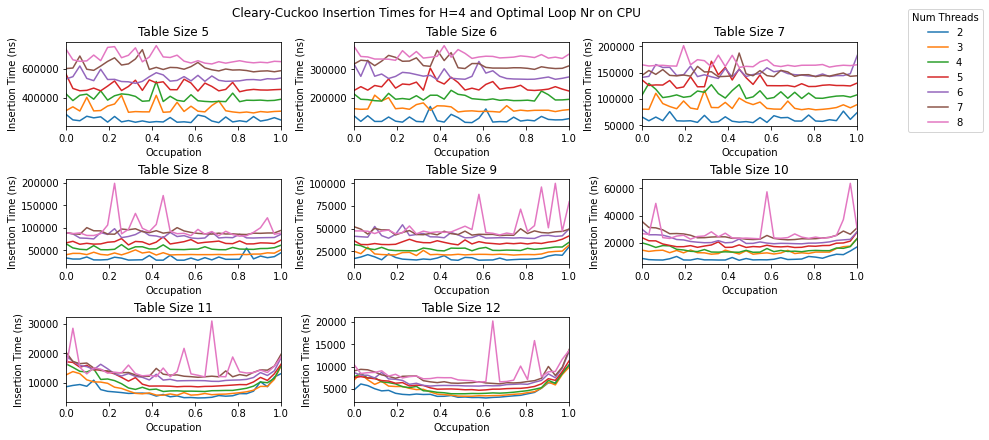

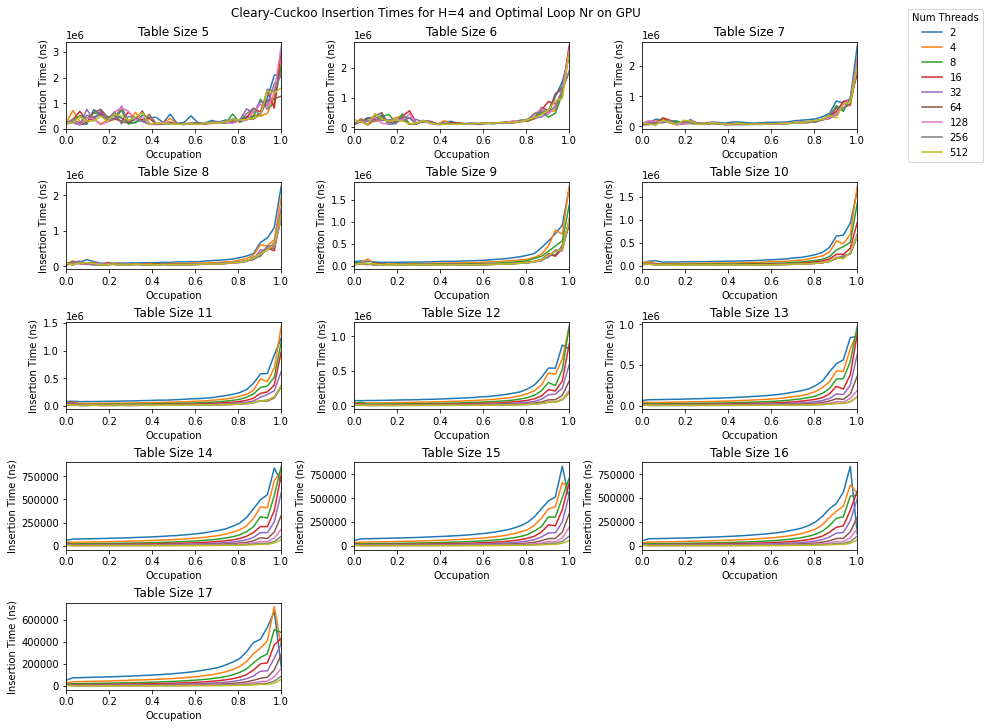

In [15]:
def plotFillByThreads(T, table="", dataset="", MAX_TABLESIZE=math.inf):
    tables = removeDups((T[T['tablesize'] <= MAX_TABLESIZE])['tablesize'])
    numIntervals = T['interval'].max()
    #maxval = 0
    #for T in Ts:
    #    T_avg = T.groupby(['tablesize', 'numthreads', 'interval']).mean().drop(['samples'], axis=1)
    #    T_avg = T_avg.reset_index()
    #    print(T_avg['time'].max())
    #    maxval = max(maxval, T_avg['time'].max())
            #Average the samples
    T_avg = T.groupby(['tablesize', 'numthreads', 'interval']).mean().drop(['samples'], axis=1)
    T_avg = T_avg.reset_index()
    
    T_avg['occupation'] = T_avg['interval']/T_avg['interval'].max()

    fig = plt.figure(constrained_layout=True, figsize=(12, 2*math.ceil(len(tables)/3) ))
    subfigs = fig.subplots(math.ceil(len(tables)/3), 3)
    
    fig.suptitle(getTableString(table) +" Insertion Times for H=4 and Optimal Loop Nr on " + getTitleString(dataset))
    
    x=0
    #Iterate over tablesizes
    for i in tables:
        tableN = T_avg[T_avg['tablesize'] == i]
        #Iterate over the number of threads
        for j in removeDups(tableN['numthreads']):
            threadN = tableN[tableN['numthreads'] == j]
            subfigs[math.floor(x/3), x%3].plot(threadN['occupation'], threadN['time'])
        subfigs[math.floor(x/3), x%3].title.set_text("Table Size " + str(i))
        subfigs[math.floor(x/3), x%3].set(xlabel="Occupation", ylabel='Insertion Time (ns)')
        subfigs[math.floor(x/3), x%3].set_xlim(0,T_avg['occupation'].max())
        #plt.ylim([0, T_avg['time'].max()])
        x+=1
    
    #clean empty plots
    numEmpty = len(tables)%3
    if numEmpty !=0 : numEmpty = 3 - numEmpty
    for i in range(1, numEmpty+1):
        subfigs[-1,-1*i].axis('off')
    
    fig.legend(subfigs[0,0].get_lines(), removeDups(T_avg['numthreads']),title="Num Threads", bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()
    
    if dataset!="":
        filename = table + "Fill_" + dataset + ".png"
        fig.savefig(imageFolder + filename, bbox_inches='tight')

        
plotFillByThreads(filterTable(ccfill_ins_CPU, numthreads=8), "cc", "CPU", MAX_TABLESIZE=12)
plotFillByThreads(ccfill_ins_GPU, "cc", "GPU", MAX_TABLESIZE=17)

### Comparison

In [16]:
#Import Table
def importSpeed(filename):
    df = pd.read_csv (filename, index_col=False)
    #df= pd.concat([df, df2])

    #Filter by table type
    ccspeed = df[df['type'] == "cuc"]
    cspeed = df[df['type'] == "cle"]
    
    #Get the number of intervals
    numIntervals = df['interval'].max()

    #Remove Times after Fail
    ccspeed = ccspeed[ccspeed["time"] != -1]
        
    #Filter lookup and insert
    ccspeed_ins = ccspeed[ccspeed['test'].str.contains("INS")]
    ccspeed_look = ccspeed[ccspeed['test'].str.contains("LOOK")]
        
    cspeed_ins = cspeed[cspeed['test'].str.contains("INS")]
    cspeed_look = cspeed[cspeed['test'].str.contains("LOOK")]
    
    return ccspeed_ins, ccspeed_look, cspeed_ins, cspeed_look

ccspeed_ins_CPU, ccspeed_look_CPU, cspeed_ins_CPU, cspeed_look_CPU = importSpeed(dataFolder + '\\benchspeed-CPU.csv')
ccspeed_ins_GPU, ccspeed_look_GPU, cspeed_ins_GPU, cspeed_look_GPU = importSpeed(dataFolder + '\\benchspeed-GPU.csv')

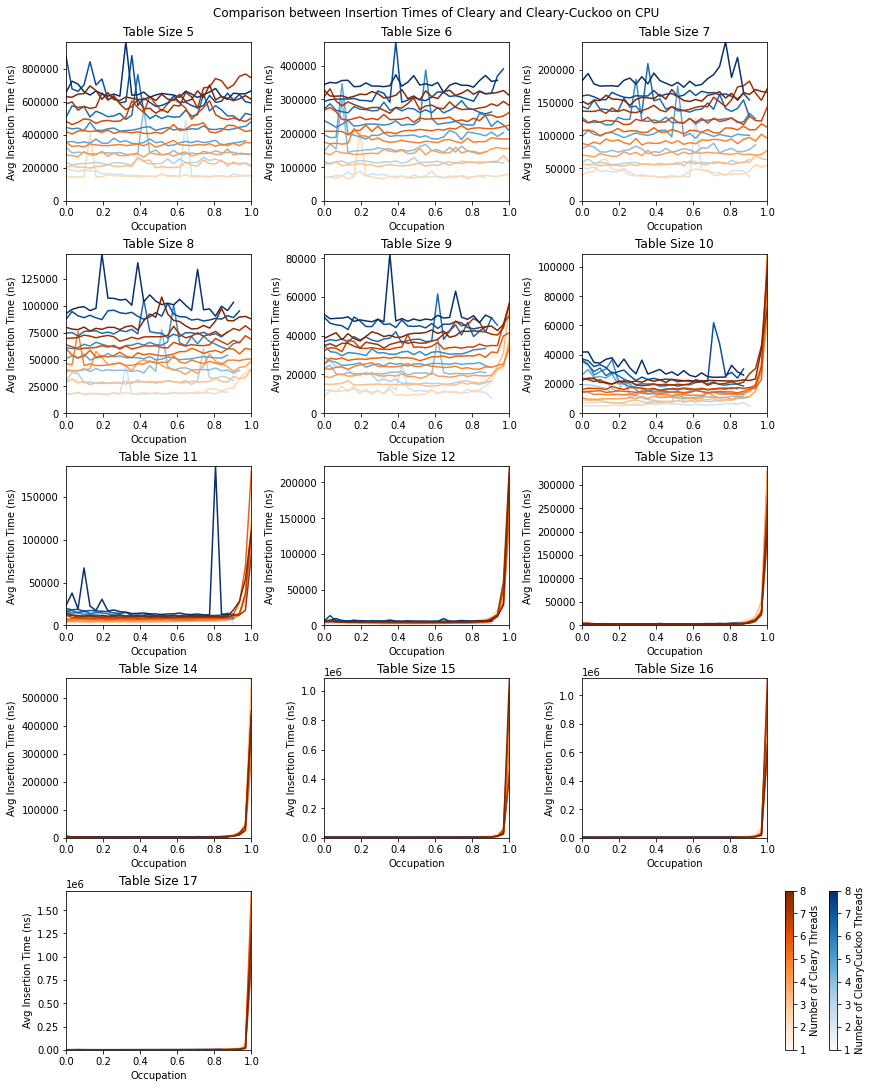

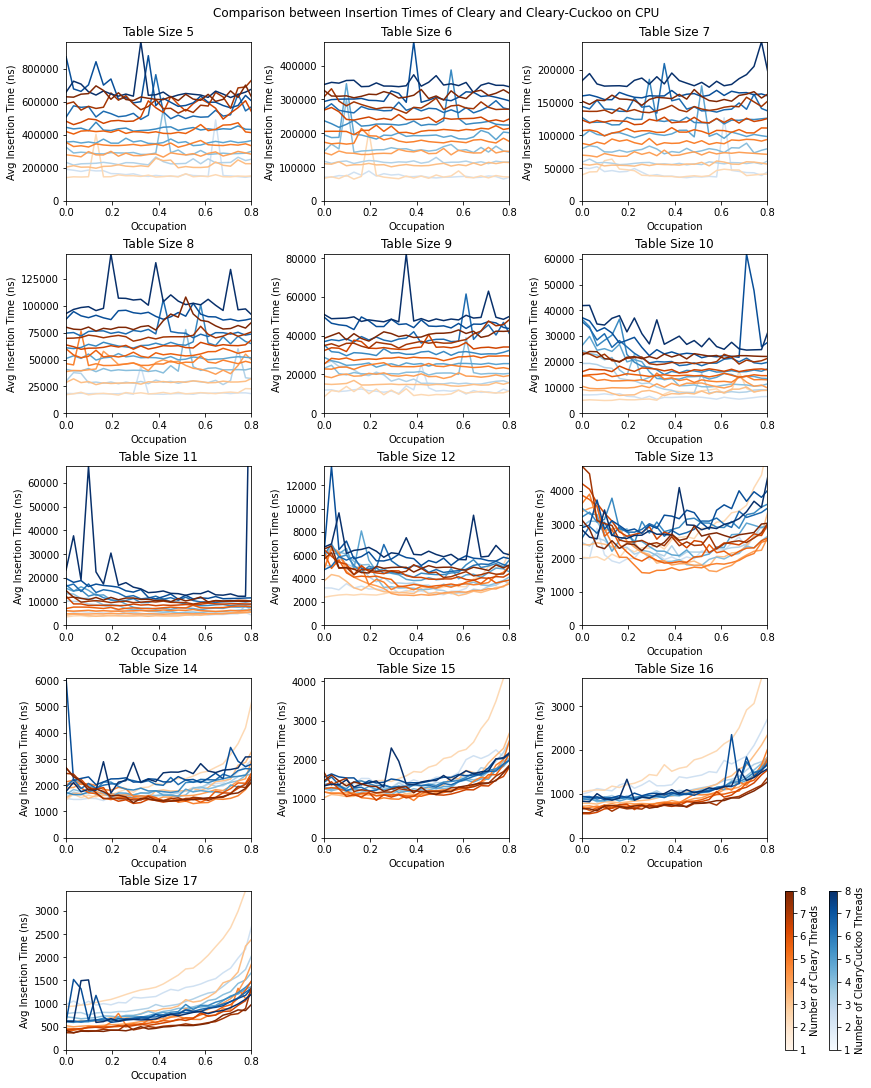

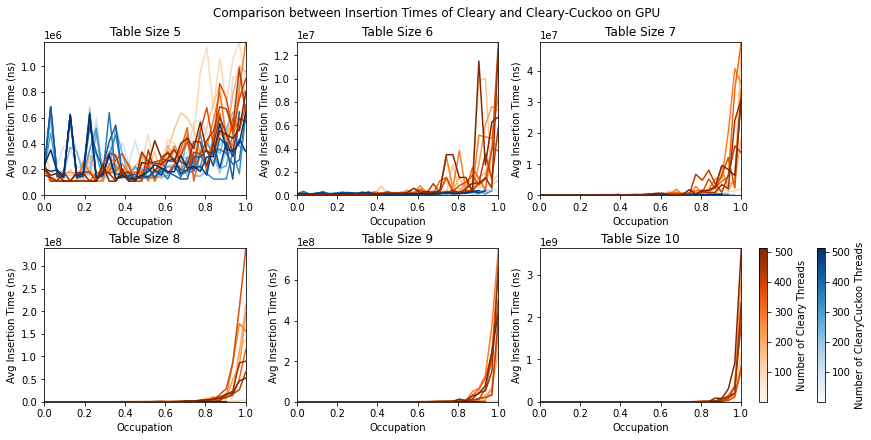

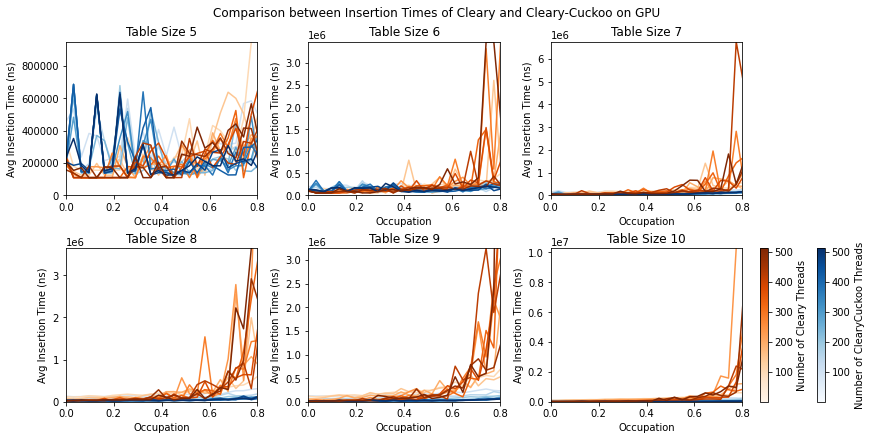

In [17]:
def PlotInsertionByTableSize(T1, T2, zoom, dataset="", insert=True, MAX_TABLESIZE=math.inf):
    tables = removeDups((T1[T1['tablesize'] <= MAX_TABLESIZE])['tablesize'])
    threads = removeDups(T1['numthreads'])
    
    maxX = (T1['interval'].max())*(zoom/100)
    
    colorsT1 = pl.cm.Blues(np.linspace(0.2,1,len(threads)))
    colorsT2 = pl.cm.Oranges(np.linspace(0.2,1,len(threads)))
    
    
    T1_avg = T1.groupby(['tablesize', 'numthreads', 'interval']).mean()
    T1_avg = T1_avg.reset_index()
    T1_avg = T1_avg[['tablesize', 'numthreads', 'interval', 'time']]
    
    T2_avg = T2.groupby(['tablesize', 'numthreads', 'interval']).mean()
    T2_avg = T2_avg.reset_index()
    T2_avg = T2_avg[['tablesize', 'numthreads', 'interval', 'time']]
    
    T1_avg['occupation'] = T1_avg['interval']/T1_avg['interval'].max()
    T2_avg['occupation'] = T2_avg['interval']/T2_avg['interval'].max()
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 3*math.ceil(len(tables)/3) ))
    subfigs = fig.subplots(math.ceil(len(tables)/3), 3)
    
    figType = "Insertion"
    if not insert:
        figType = "Lookup"
    fig.suptitle("Comparison between " + figType + " Times of Cleary and Cleary-Cuckoo on " + getTitleString(dataset))
    
    x=0
    for i in tables:
        T1_N = T1_avg[T1_avg['tablesize'] == i]
        T2_N = T2_avg[T2_avg['tablesize'] == i]
        
        ax2 = subfigs[math.floor(x/3), x%3]
        ax2.set_xlabel('Occupation')
        if insert:
            ax2.set_ylabel('Avg Insertion Time (ns)')
        else:
            ax2.set_ylabel('Avg Lookup Time (ns)')
        ax2.title.set_text("Table Size " + str(i))
        
        maxY1 = (T1_N[T1_N['interval'] <= maxX ])['time'].max()
        maxY2 = (T2_N[T2_N['interval'] <= maxX ])['time'].max()
        maxY = max(maxY1, maxY2)
        
        y=0
        for j in threads:
            T1_NT = T1_N[T1_N['numthreads'] == j]
            T2_NT = T2_N[T2_N['numthreads'] == j]
            
            if (x==0):
                lab = j
            else:
                lab = '_nolegend_'
        
            ax2.plot(T1_NT['occupation'], T1_NT['time'], label=lab, color=colorsT1[y])
            ax2.plot(T2_NT['occupation'], T2_NT['time'], label=lab, color=colorsT2[y])
            y+=1
        ax2.axis(xmin=0,xmax=maxX/T1_avg['interval'].max())
        ax2.axis(ymin=0,ymax=maxY)
        
        x+=1
    
    norm = mpl.colors.Normalize(vmin=T1['numthreads'].min(), vmax=T1['numthreads'].max())
        
    fig.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=pl.cm.Blues),
              orientation='vertical', label='Number of ClearyCuckoo Threads')
    fig.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=pl.cm.Oranges),
              orientation='vertical', label='Number of Cleary Threads')
    #fig.legend(title="Num Threads")
    
    #clean empty plots
    numEmpty = len(tables)%3
    if numEmpty !=0 : numEmpty = 3 - numEmpty
    for i in range(1, numEmpty+1):
        subfigs[-1,-1*i].axis('off')
    
    if dataset!="":
        filename = "Speed_" + dataset + "_" + figType + "_" + str(zoom) + ".png"
        fig.savefig(imageFolder + filename, bbox_inches='tight')

        
PlotInsertionByTableSize(filterTable(ccspeed_ins_CPU, numthreads=8), filterTable(cspeed_ins_CPU, numthreads=8), 100, "CPU", MAX_TABLESIZE=17) 
PlotInsertionByTableSize(filterTable(ccspeed_ins_CPU, numthreads=8), filterTable(cspeed_ins_CPU, numthreads=8), 80, "CPU", MAX_TABLESIZE=17)

PlotInsertionByTableSize(ccspeed_ins_GPU, cspeed_ins_GPU, 100, "GPU", MAX_TABLESIZE=10)
PlotInsertionByTableSize(ccspeed_ins_GPU, cspeed_ins_GPU, 80, "GPU", MAX_TABLESIZE=10)

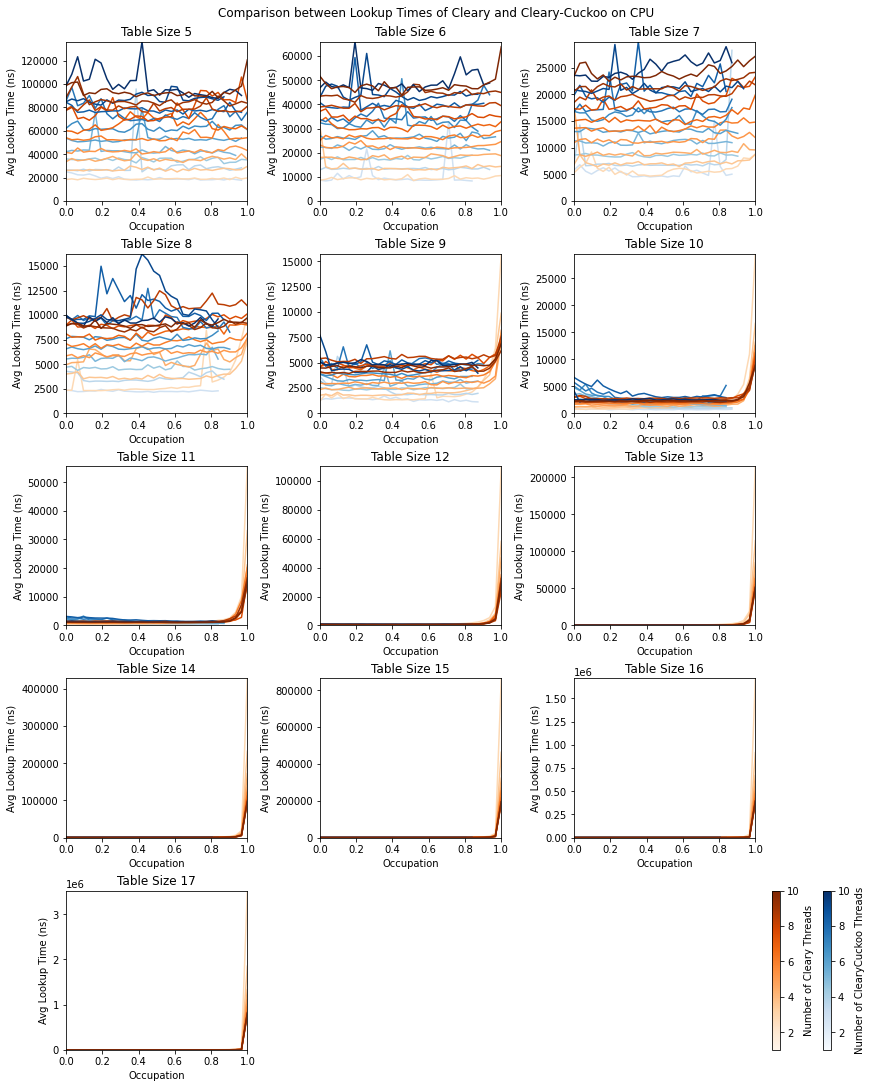

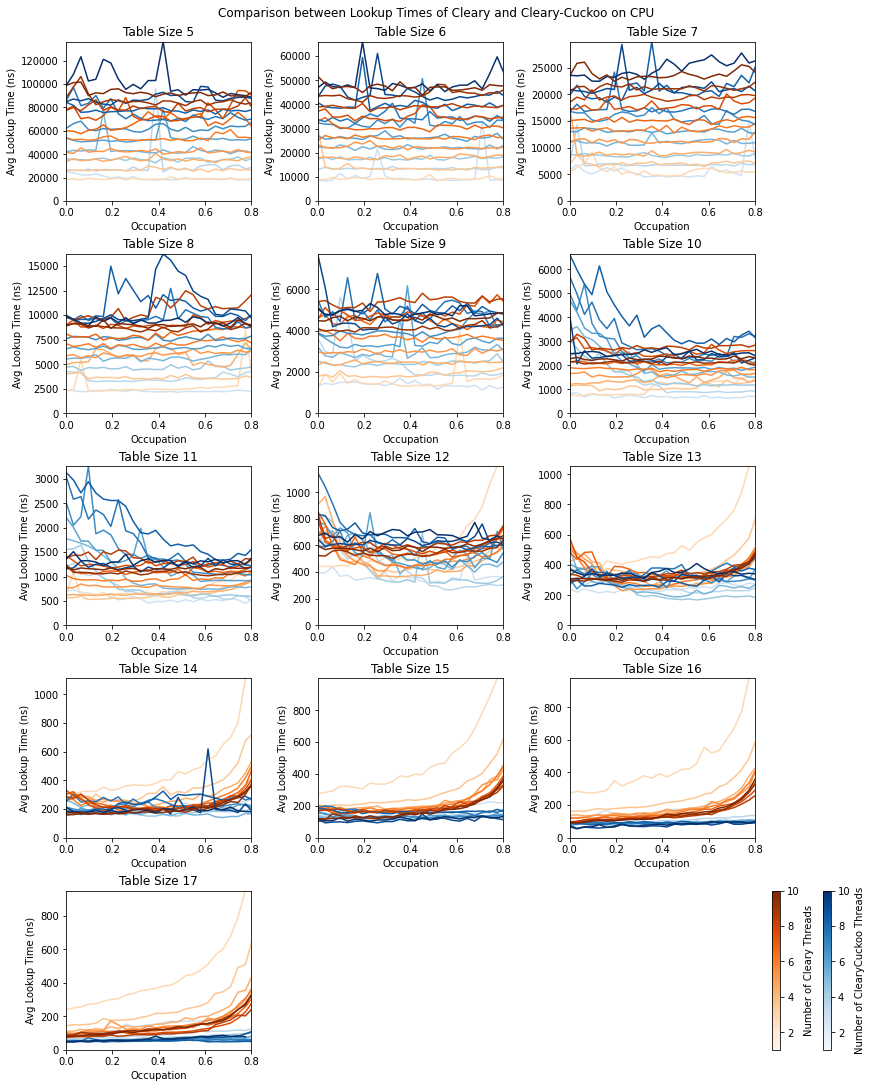

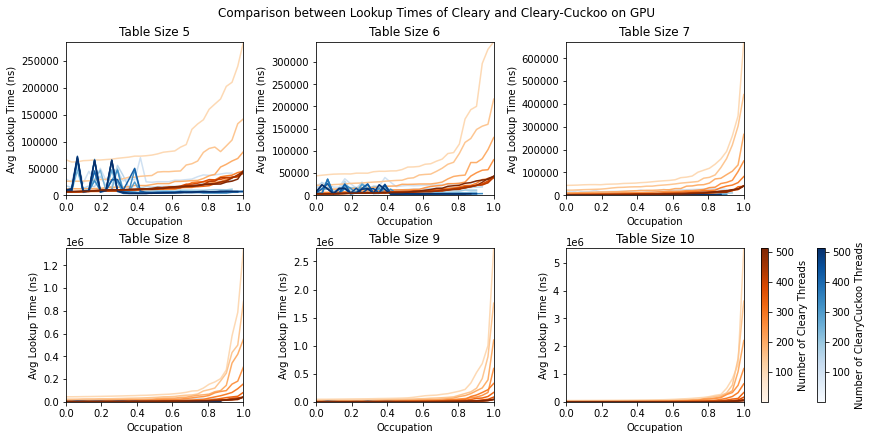

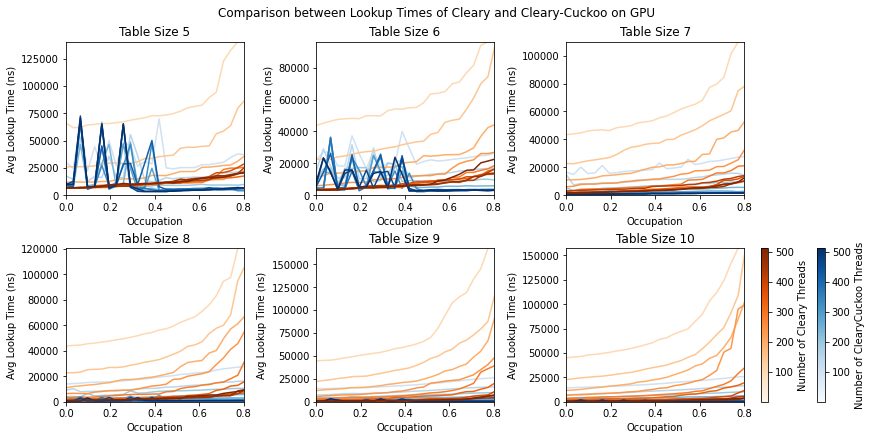

In [18]:
PlotInsertionByTableSize(ccspeed_look_CPU, cspeed_look_CPU, 100, "CPU", insert=False, MAX_TABLESIZE=17)
PlotInsertionByTableSize(ccspeed_look_CPU, cspeed_look_CPU, 80, "CPU", insert=False, MAX_TABLESIZE=17)
        
PlotInsertionByTableSize(ccspeed_look_GPU, cspeed_look_GPU, 100, "GPU", insert=False, MAX_TABLESIZE=10)
PlotInsertionByTableSize(ccspeed_look_GPU, cspeed_look_GPU, 80, "GPU", insert=False, MAX_TABLESIZE=10)

# CCMAX Bucket

In [20]:
#Import max table
def importMax(filename):
    #ccmax = pd.read_csv (r'results\benchmax.csv', index_col=False)
    ccmax = pd.read_csv (filename, index_col=False)
    #Average the samples
    ccmax = ccmax.groupby(['tablesize', 'hashes', 'loops', 'bucketsize']).mean().drop(['samples'], axis=1)
    ccmax = ccmax.reset_index() 
    ccmax['occupation'] = ccmax['max']/(pow(2,ccmax['tablesize'])*ccmax['bucketsize'])
    return ccmax
    
ccmax_CPU = importMax(dataFolder + 'benchmaxbucket-GPU.csv')

In [21]:
ccmax_CPU

tablesize  hashes  loops  bucketsize   max  occupation
0            4       1      0           1     0    0.000000
1            4       1      0           5     0    0.000000
2            4       1      0           9     0    0.000000
3            4       1      0          13     0    0.000000
4            4       1     30           1     4    0.250000
..         ...     ...    ...         ...   ...         ...
742          8       3    150           9  2303    0.999566
743          8       3    150          13  3327    0.999700
744          8       3    180           1   233    0.910156
745          8       3    180           5  1279    0.999219
746          8       3    180           9  2303    0.999566

[747 rows x 6 columns]